In [1]:
# Imports
import contextily as cx 
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.neighbors import NearestNeighbors

# Inverse distance weighted interpolation

### Read and prepare data

In [2]:
# Read data from .csv file, drop apartments without location data
df = pd.read_csv("data/20-04-23.csv")
df = df[df.longitude != 0.0]
df.head()

,id,rooms,area,rent,latitude,longitude
0,5248131,1,38,5216,55.652406,12.512200
1,5275700,1,37,7900,55.671065,12.501394
2,5211187,1,40,6300,55.649554,12.551497
3,5263181,3,73,11000,55.663465,12.542260
4,5249720,3,73,11000,55.663465,12.542260


In [3]:
# Add column for normalised rent = rent / area
df["norm_rent"] = round(df.rent / df.area, 2)
df.head()

,id,rooms,area,rent,latitude,longitude,norm_rent
0,5248131,1,38,5216,55.652406,12.512200,137.26
1,5275700,1,37,7900,55.671065,12.501394,213.51
2,5211187,1,40,6300,55.649554,12.551497,157.50
3,5263181,3,73,11000,55.663465,12.542260,150.68
4,5249720,3,73,11000,55.663465,12.542260,150.68


In [4]:
# Save dataframe with new column 'norm_rent' to .csv file
# df.to_csv('data/20-04-23_norm.csv', index=False)

In [5]:
# Create GeoDataFrame from Pandas DataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs="EPSG:4326")
gdf.head()

,id,rooms,area,rent,latitude,longitude,norm_rent,geometry
0,5248131,1,38,5216,55.652406,12.512200,137.26,POINT (12.51220 55.65241)
1,5275700,1,37,7900,55.671065,12.501394,213.51,POINT (12.50139 55.67106)
2,5211187,1,40,6300,55.649554,12.551497,157.50,POINT (12.55150 55.64955)
3,5263181,3,73,11000,55.663465,12.542260,150.68,POINT (12.54226 55.66347)
4,5249720,3,73,11000,55.663465,12.542260,150.68,POINT (12.54226 55.66347)


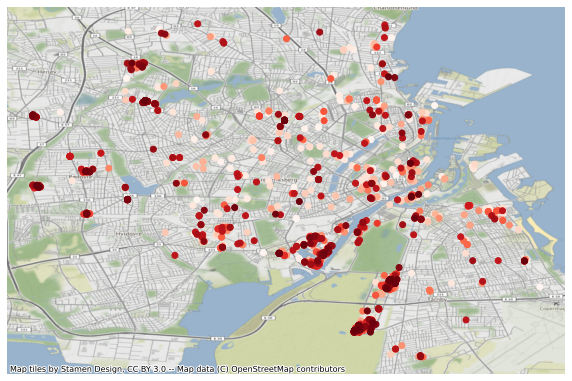

In [6]:
# Visualise 
ax = gdf.plot(c=gdf["norm_rent"], cmap='Reds', figsize=(10,10))
ax.set_axis_off()
cx.add_basemap(ax, crs=gdf.crs)

### Grid for interpolation

In [7]:
# Borders of the grid for interpolation
lon_min, lat_min, lon_max, lat_max = gdf.geometry.total_bounds
print(f"lon: {lon_max}-{lon_min}, lat: {lat_max}-{lat_min}")

lon: 12.642434-12.433844, lat: 55.743446-55.606455


In [8]:
# Grid density
D = 6

# Number of nearest neighbors
K = 5

# Power parameter for IDW
P = 2

In [9]:
# Create grid of points
x = np.linspace(lon_min, lon_max, 5*D)
y = np.linspace(lat_min, lat_max, 4*D)
x, y = np.meshgrid(x, y)
grid = np.column_stack((x.ravel(), y.ravel()))

In [10]:
# Create grid DataFrame and GeoDataFrame 
grid_df = pd.DataFrame(grid, columns=['longitude', 'latitude'])
grid_gdf = gpd.GeoDataFrame(grid_df, geometry=gpd.points_from_xy(grid_df.longitude, grid_df.latitude), crs="EPSG:4326")
grid_gdf.head()

,longitude,latitude,geometry
0,12.433844,55.606455,POINT (12.43384 55.60645)
1,12.441037,55.606455,POINT (12.44104 55.60645)
2,12.448230,55.606455,POINT (12.44823 55.60645)
3,12.455422,55.606455,POINT (12.45542 55.60645)
4,12.462615,55.606455,POINT (12.46262 55.60645)


In [11]:
# Visualise grid
# ax = grid_gdf.plot(figsize=(10, 10))
# ax.set_axis_off()
# cx.add_basemap(ax, crs=gdf.crs)

### Find nearest neighbors

In [12]:
# Put apartment coordinates into numpy array
apartments = np.array([[row.longitude, row.latitude] for index, row in df.iterrows()])

# Put grid point coordinates into numpy array
grid = np.array(grid)

# Fit apartment coordinates into nearest neighbors
nbrs = NearestNeighbors(n_neighbors=K, algorithm='ball_tree').fit(apartments)

# Find k nearest neighbors - k nearest apartments to grid points
distances, indices = nbrs.kneighbors(grid)

# Get unique set of neighbors
unique_indices = set(indices.flatten())
neighbors = gdf[gdf.index.isin(unique_indices)].copy()

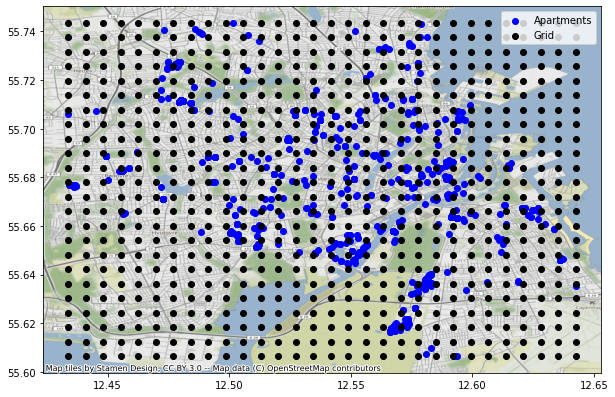

In [13]:
# Visualise grid points and its neighbors
fig, ax = plt.subplots(figsize=(10, 10))
neighbors.plot(ax=ax, color='blue')
grid_gdf.plot(ax=ax, color='black')
ax.legend(['Apartments', 'Grid'], loc='upper right')
cx.add_basemap(ax, crs=gdf.crs)
plt.show()

### Formula for IDW interpolation

$$
z_p = 
\frac{
        \sum_{i=1}^{n}
        \big( 
            \frac{z_i}{{d_i}^p}
        \big)
    }
    {
        \sum_{i=1}^{n}
        \big( 
            \frac{1}{{d_i}^p}
        \big)
    }
$$

$$
z_p - \text{interpolated value with a given power p} \\
z_i - \text{value at known point i} \\
d_i - \text{distance to the known point i} \\
p - \text{power}
$$
source:
https://gisgeography.com/inverse-distance-weighting-idw-interpolation/

In [14]:
# Interpolate value of normalised rent over grid of points
interpolated_norm_rent = []
for i, d in zip(indices, distances):
    norm_rent = [df.iloc[_].norm_rent for _ in i]
    numerator = norm_rent / (d**P)
    denominator = 1 / (d**P)
    interpolated_norm_rent.append(sum(numerator) / sum(denominator))

In [15]:
# Add interpolated values as a new column of the existing DataFrame
grid_gdf["interpolated_norm_rent"] = interpolated_norm_rent

In [16]:
# Convert dataframe columns into arrays
longitude = grid_df["longitude"].values
latitude = grid_df["latitude"].values
interpolated_norm_rent = grid_df["interpolated_norm_rent"].values

In [17]:
grid = np.reshape(interpolated_norm_rent, (4*D, 5*D))
# grid

In [18]:
neighbors.head()

,id,rooms,area,rent,latitude,longitude,norm_rent,geometry
0,5248131,1,38,5216,55.652406,12.512200,137.26,POINT (12.51220 55.65241)
1,5275700,1,37,7900,55.671065,12.501394,213.51,POINT (12.50139 55.67106)
3,5263181,3,73,11000,55.663465,12.542260,150.68,POINT (12.54226 55.66347)
4,5249720,3,73,11000,55.663465,12.542260,150.68,POINT (12.54226 55.66347)
5,5142344,3,95,11000,55.695855,12.572995,115.79,POINT (12.57300 55.69586)


In [19]:
# # Create a figure and axes
# fig, ax = plt.subplots(figsize=(15, 10))

# # Plot the grid using imshow
# im = ax.imshow(grid, extent=(lon_min, lon_max, lat_min, lat_max), cmap='rainbow', interpolation='gaussian')

# # Scatter plot of neighbors
# sc = ax.scatter(neighbors.longitude, neighbors.latitude, c=neighbors.norm_rent, cmap='rainbow', edgecolors='black')

# # Add the basemap using contextily
# cx.add_basemap(ax, crs=gdf.crs, source=cx.providers.CartoDB.DarkMatter)

# # Add a colorbar
# cbar = plt.colorbar(sc)

# # Show the plot
# plt.show()

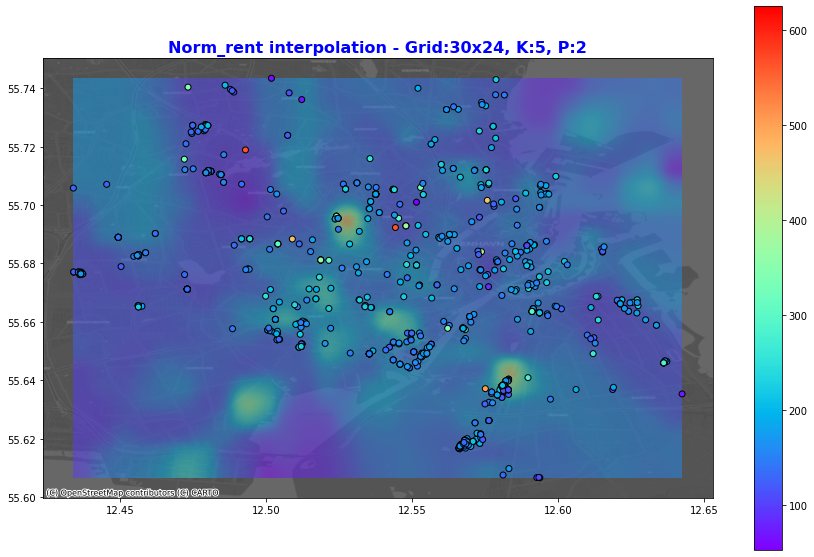

In [20]:
# Create a figure and axes
fig, ax = plt.subplots(figsize=(15, 10))

# Scatter plot of neighbors
sc = ax.scatter(neighbors.longitude, neighbors.latitude, c=neighbors.norm_rent, cmap='rainbow', edgecolors='black')

# Add the basemap using contextily
cx.add_basemap(ax, crs=gdf.crs, source=cx.providers.CartoDB.DarkMatter, alpha=0.7)

# Plot the interpolation grid using imshow with transparency
im = ax.imshow(grid, extent=(lon_min, lon_max, lat_min, lat_max), cmap='rainbow', interpolation='gaussian', alpha=0.5)

# Add a colorbar
cbar = plt.colorbar(sc)

# Add title
plt.title(f"Norm_rent interpolation - Grid:{5*D}x{4*D}, K:{K}, P:{P}", fontsize=16, fontweight="bold", color="blue")

# Save plot
plt.savefig(f"plots/D:{D}_K:{K}_P:{P}.png", dpi=300) 

# Show the plot
plt.show()

# Release resources
plt.close()